             jetPt    jetEta    jetPhi    jetMass  jetGirth   jetArea  \
0       201.199554 -0.455842 -1.927541  20.587746  0.041613  0.488692   
1       154.892838  0.014880  1.769757  18.438292  0.065008  0.488692   
2       105.403564 -2.155736  0.339309  17.063622  0.079528  0.478719   
3      1263.015747  0.024581 -1.778938  65.909691  0.019175  0.498666   
4       742.551147 -0.602228  1.542989  67.713173  0.044115  0.488692   
...            ...       ...       ...        ...       ...       ...   
41174    31.793331  0.409326 -0.741884   6.045236  0.135822  0.528585   
41175   351.622528  0.840648 -0.485934  41.364834  0.071550  0.478719   
41176   204.383728 -0.650319  2.484838  18.191933  0.034900  0.518612   
41177    53.887554  0.245099  3.121343   9.654922  0.143202  0.518612   
41178    31.789476  0.226360 -2.714607   2.704221  0.063469  0.359039   

          jetRawPt  jetRawMass  jetLooseID  jetTightID  ...   lumi  \
0       191.304138   19.575197           1           

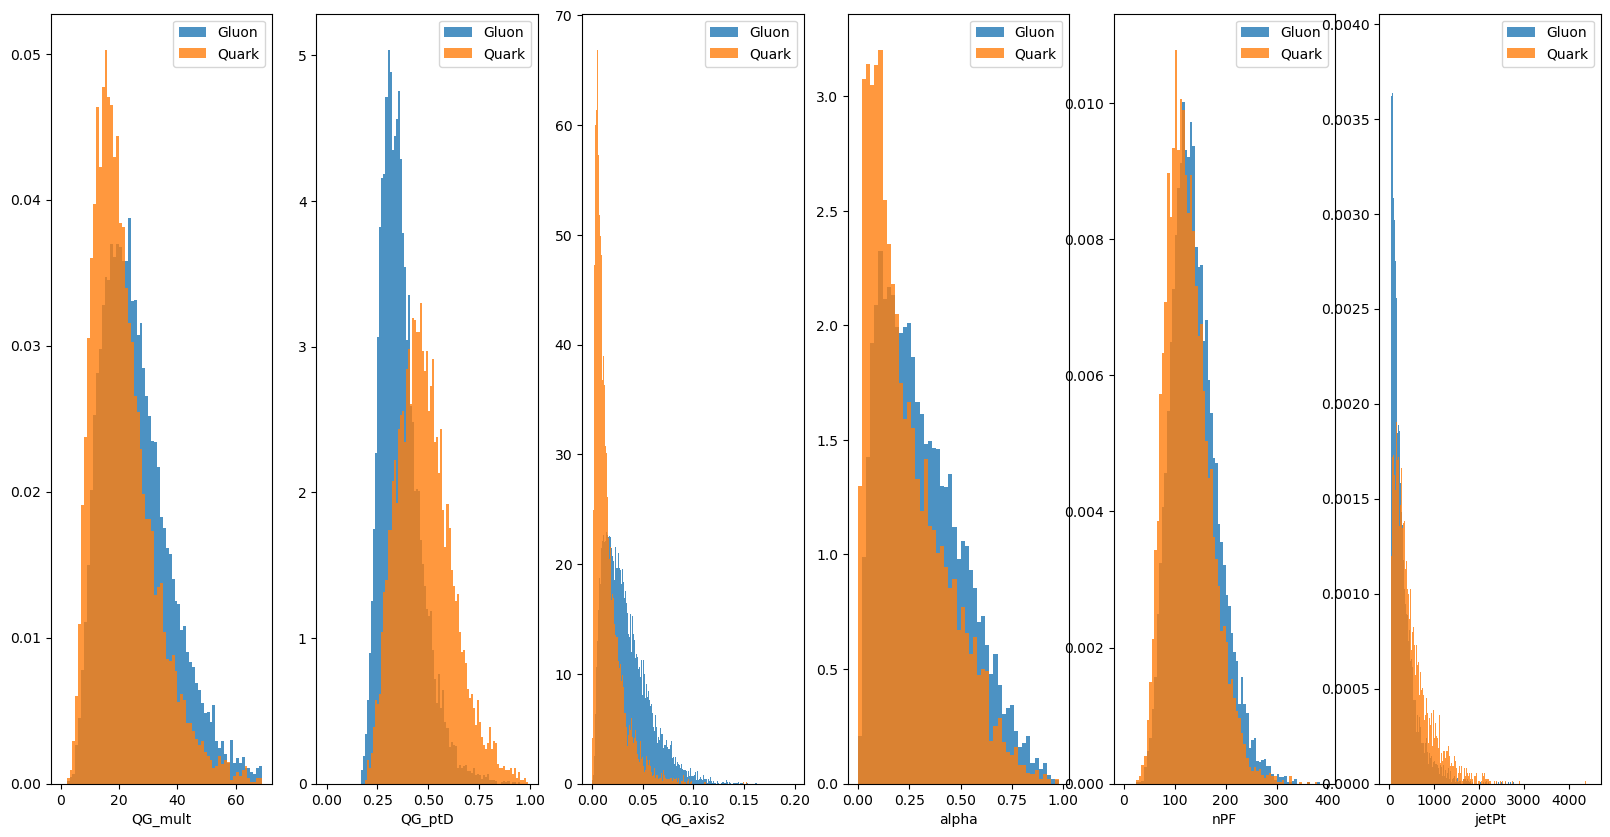

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uproot

filePath='output.root'
rootFile = uproot.open(filePath)['AK4jets']['jetTree']

df = pd.DataFrame()
df = uproot.open(filePath)['AK4jets']['jetTree'].arrays(library="pd")

print(df)

df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()
hist_columns = ["QG_mult", "QG_ptD", "QG_axis2","alpha","nPF","jetPt"]
binnings = [np.arange(0,70,1), np.arange(0.0,1.0,0.01), np.arange(0.0,0.2,0.001),np.arange(0,1,0.02),np.arange(0,400,5),np.arange(0,4500,10)]
ind = 0
fig, axes = plt.subplots(1,6, figsize=(20,10))

for column in hist_columns:
    axes[ind].hist( df[df.isPhysG==1][column], bins=binnings[ind], alpha=0.8, label='Gluon', density=1 )
    axes[ind].hist( df[df.isPhysUDS==1][column], bins=binnings[ind], alpha=0.8, label='Quark', density=1 )
    axes[ind].set_xlabel(column)
    axes[ind].legend()
    ind = ind+1
    
plt.savefig("grafik.png")

In [2]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputClassifier

X = df[["QG_mult", "QG_ptD", "QG_axis2","alpha","nPF","jetPt"]].values
y = df[["isPhysUDS","isPhysG"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train,X_valid ,y_train, y_valid = train_test_split(X_train,y_train ,test_size =0.2 , random_state = 42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_valid = scaler.fit_transform(X_valid)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)            
y_valid = scaler.fit_transform(y_valid)


#model = MultiOutputClassifier(xgb.XGBClassifier(objective="multi:softmax",num_class=2)) #2den daha fazla sınıfa ayrılacak ise bu kullanılmalı
model = xgb.XGBClassifier(objective="binary:logistic", eval_metric = ["error","logloss"],alpha= 1.5679691463026137, colsample_bytree= 0.9279535826041942, gamma= 0.8156297940758337, grow_policy= "depthwise", learning_rate= 0.06402322319301305, max_depth= 3, max_leaves= 2, min_child_weight= 5, min_split_loss =1.696672762518408, n_estimators= 148, scale_pos_weight= 0.9372997693745585, subsample= 0.6832351898075176, tree_method= "exact") #sadece 2 sınıfa ayrılacak ise bunu kullanmak yeterli
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train,eval_set=eval_set, verbose=True)

y_pred = model.predict(X_test)
#tahmin_sonuclari = np.where(y_pred, 'kuark', 'gluon')

df['y_target'] = df.apply(lambda row: '0' if row['isPhysG'] == 1 else '1', axis=1) # 0= "gluon" , 1="kuark"
y_pred_p = model.predict_proba(X_test)

y_pred_combined = np.where(y_pred_p[:, 0] > 0.5, 'Kuark', 'Gluon')
y_test_combined = np.where(y_test[:, 0] == 1, 'Kuark', 'Gluon')

print("Tahmin edilen:", y_pred_combined)
print("Gerçek değerler:", y_test_combined)

results = model.evals_result()
train_errors = results['validation_0']['error']
validation_errors = results['validation_1']['error']
train_losses = results['validation_0']['logloss']
validation_losses = results['validation_1']['logloss']

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, ))
#print("durumlar:",tahmin_sonuclari)
print("tahmin:",y_pred)
print("y_pred_p:",y_pred_p)
print("gerçek:",y)
print("durumlar:",df["y_target"])

[0]	validation_0-error:0.29284	validation_0-logloss:0.67494	validation_1-error:0.29938	validation_1-logloss:0.67600
[1]	validation_0-error:0.25975	validation_0-logloss:0.65880	validation_1-error:0.26979	validation_1-logloss:0.66068
[2]	validation_0-error:0.25332	validation_0-logloss:0.64388	validation_1-error:0.26217	validation_1-logloss:0.64634
[3]	validation_0-error:0.25164	validation_0-logloss:0.63104	validation_1-error:0.25655	validation_1-logloss:0.63391
[4]	validation_0-error:0.25047	validation_0-logloss:0.61949	validation_1-error:0.25755	validation_1-logloss:0.62292
[5]	validation_0-error:0.25043	validation_0-logloss:0.60895	validation_1-error:0.25643	validation_1-logloss:0.61268
[6]	validation_0-error:0.24852	validation_0-logloss:0.59916	validation_1-error:0.25368	validation_1-logloss:0.60323
[7]	validation_0-error:0.24797	validation_0-logloss:0.59060	validation_1-error:0.25443	validation_1-logloss:0.59511
[8]	validation_0-error:0.24567	validation_0-logloss:0.58271	validation_1

C:\Users\emre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


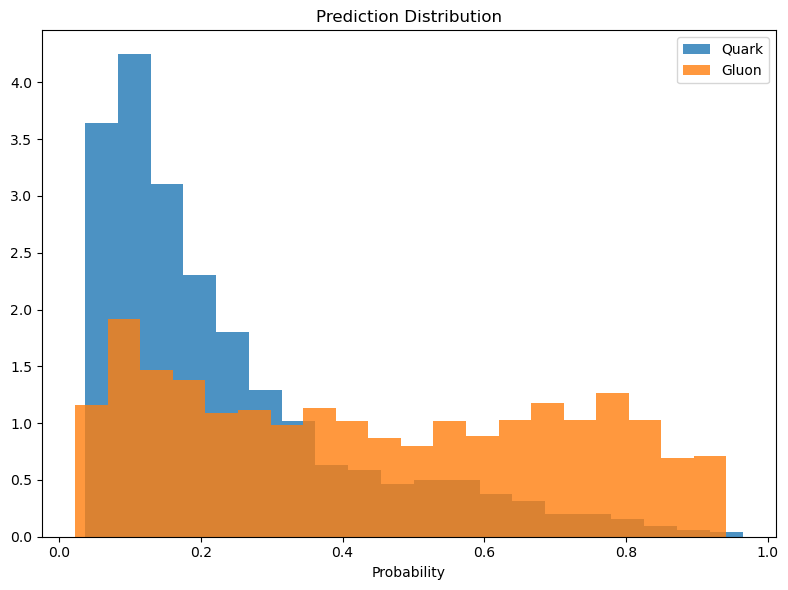

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction_distribution(y_true, y_pred_proba, class_names):
    num_bins = 20

    plt.figure(figsize=(8, 6))

    for i in range(len(class_names)):
        plt.hist(y_pred_proba[y_true == i][:, i], bins=num_bins, alpha=0.8, label=class_names[i], density=1)

    plt.xlabel('Probability')
    plt.title('Prediction Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Örnek kullanım
class_names = ['Quark', 'Gluon']  # Sınıf isimleri
y_true = np.where(y_test[:, 0] == 1, 1, 0)  # Gerçek etiketler
y_pred_proba = y_pred_p  # XGBoost tahmin olasılıkları

plot_prediction_distribution(y_true, y_pred_proba, class_names)


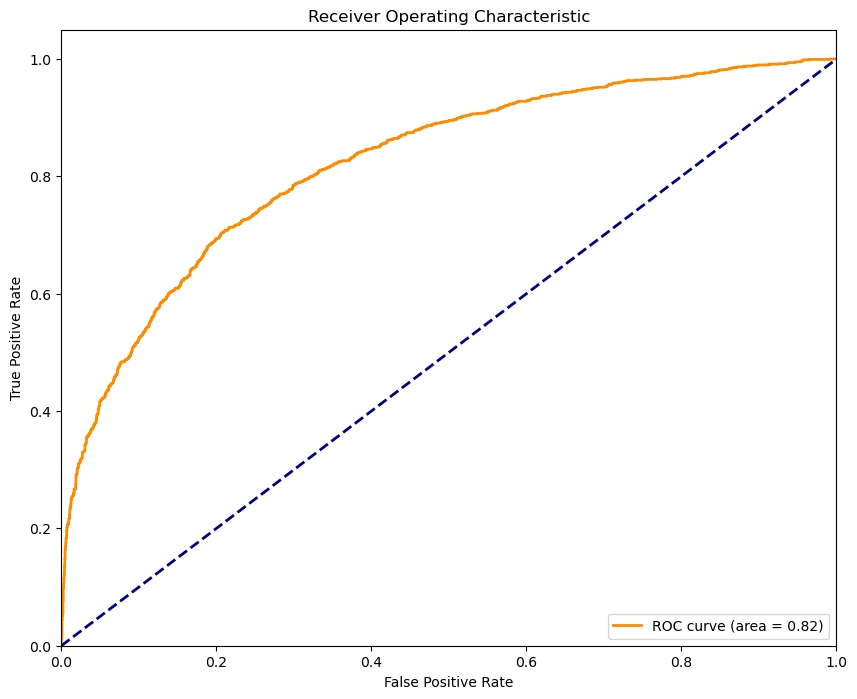

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Modelin tahmin ettiği olasılıkları alın
y_scores = model.predict_proba(X_test)[:, 0]

# ROC eğrisini ve AUC'yi hesaplayın
fpr, tpr, _ = roc_curve(y_test[:, 0], y_scores)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizin
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.savefig("Roc_Curve.png")

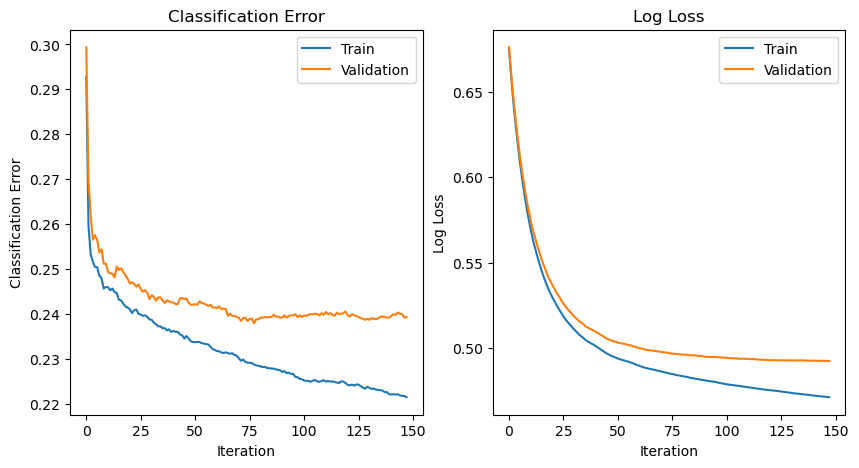

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_errors, label='Train')
plt.plot(validation_errors, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Classification Error')
plt.title('Classification Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Log Loss')
plt.legend()

plt.savefig('classification_metrics.png')

plt.show()

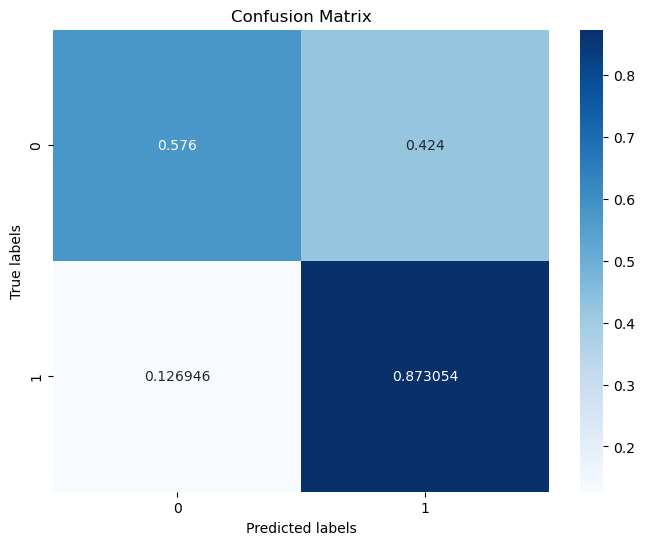

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test_binary = np.argmax(y_test, axis=1)
y_pred_binary = np.argmax(y_pred, axis=1)
#cm = confusion_matrix(y_test_binary, y_pred_binary)

conf_matrix = confusion_matrix(y_test_binary, y_pred_binary > 0.5)

actual_totals = np.sum(conf_matrix, axis=1)

percentages = (conf_matrix.T / actual_totals).T

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(percentages, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.savefig('Confusion_Matrix.png')

plt.show()

In [7]:
import numpy as np
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'alpha': hp.uniform('alpha', 0, 2),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'lambda': hp.uniform('lambda', 0, 2),
    'n_estimators': hp.quniform('n_estimators', 1, 200, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 2),
    'tree_method': hp.choice('tree_method', ['auto', 'exact', 'approx', 'hist']),
    'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),
    'max_leaves': hp.quniform('max_leaves', 0, 2, 1),
    'min_split_loss': hp.uniform('min_split_loss', 0, 2),
}

# Optimizasyon fonksiyonunu tanımla
def objective(params):
    params['max_depth'] = int(params['max_depth'])  # max_depth tam sayı olmalı
    params['n_estimators'] = int(params['n_estimators'])  # n_estimators tam sayı olmalı
    params['min_child_weight'] = int(params['min_child_weight'])  # min_child_weight tam sayı olmalı
    params['max_leaves'] = int(params['max_leaves'])  # max_leaves tam sayı olmalı
    clf = xgb.XGBClassifier(objective='binary:logistic', **params, eval_metric=['error', 'logloss'], early_stopping_rounds=10)
    clf.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False)
    best_error_score = 1 - clf.best_score  # error score'u hesapla
    best_loss_score = clf.best_score  # loss score'u hesapla
    return {'loss': best_loss_score, 'error': best_error_score, 'status': 'ok'}


# Optimizasyon çalışmasını yürüt
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("En iyi hiperparametreler:", best_params)

100%|█████████████████████████████████████████████| 100/100 [00:45<00:00,  2.19trial/s, best loss: 0.48048435894818337]
En iyi hiperparametreler: {'alpha': 1.9003515955082495, 'colsample_bytree': 0.7409367215230032, 'gamma': 0.7563015567614023, 'grow_policy': 1, 'lambda': 1.4766823579744903, 'learning_rate': 0.09590354536704014, 'max_depth': 3.0, 'max_leaves': 0.0, 'min_child_weight': 1.0, 'min_split_loss': 1.9544759766644555, 'n_estimators': 135.0, 'scale_pos_weight': 1.021361714941819, 'subsample': 0.836276574921905, 'tree_method': 3}
